# Práctica 4: Segmentación de imágenes médicas

En esta práctica implementaremos un modelo UNet para la segmentación del ventrículo izquierdo en imágenes de resonancia magnética cardiaca.

* Para más detalles sobre la importancia de este problema de segmentación en imágenes de resonancia magnética cardíaca ver: https://www.frontiersin.org/articles/10.3389/fcvm.2020.00025/full

* Para más detalles sobre el modelo UNet, ver el paper original: https://arxiv.org/abs/1505.04597


# Configuración del entorno y descarga de datos

Primero procedemos a ejecutar el comando que nos va a descargar en el server las imágenes a analizar.

In [1]:
# Borrar resultados anteriores si los hubiera
#!rm -rf CMR
#!rm -rf dlmi-uba

# Bajar las imágenes para analizar
#! git clone https://gitlab.com/eferrante/dlmi-uba.git

# Instalar las dependencias necesarias
#!pip install medpy SimpleITK

# Info sobre cómo subir un dataset a google colab: https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9

In [2]:
# Activate ext autoreload 
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import skimage.io as io
import os
import numpy as np
import torch

import SimpleITK as sitk

import medpy.metric.binary as metrics

import os
import pathlib
import re

from skimage import io, transform

import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from utils.Dataset import OurDataset,Rescale,ToTensor
from utils.trainer_loss import DiceLoss

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print('Is GPU available?', torch.cuda.is_available())
print('Model of the GPU:', torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Is GPU available? True
Model of the GPU: NVIDIA GeForce RTX 2060


# Visualizando algunas imágenes de ejemplo y seteando paths

Aquí seteamos algunos paths necesarios para indicar dónde se encuentran las imágenes de train, validation y test.

También visualizaremos algunas imágenes de ejemplo.

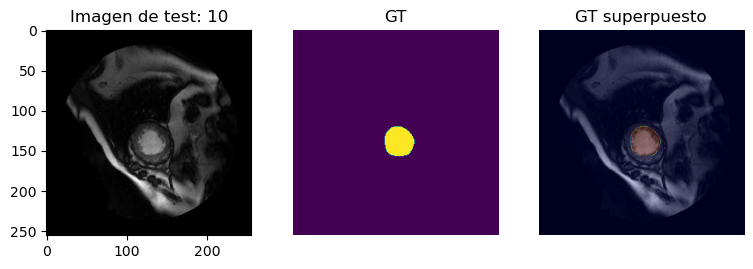

In [3]:
# Paths a los datos descargados
from utils.graphs import visualizarImagenTest
dirs = {
        'TRAIN_DATA_DIR' : "Practica4/dlmi-uba/practica3/data/Train/",
        'VAL_DATA_DIR' : "Practica4/dlmi-uba/practica3/data/Val/",
        'TEST_DATA_DIR' : "Practica4/dlmi-uba/practica3/data/Test/",

        'TEST_LABELS_DIR' : "Practica4/dlmi-uba/practica3/data/Test/Labels/",
        'TEST_IMAGES_DIR' : "Practica4/dlmi-uba/practica3/data/Test/Images/"
}
visualizarImagenTest(10,dirs)

Observamos intensidades e histograma de la imagen

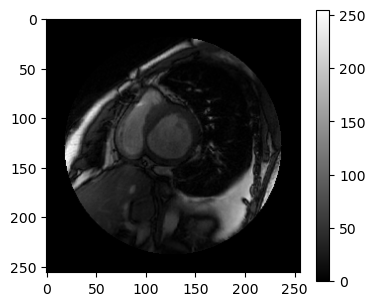

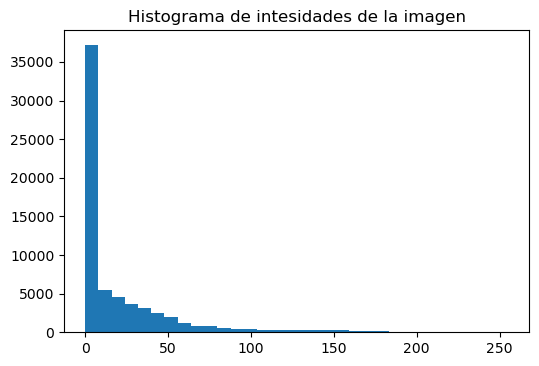

In [4]:
# Segmentación básica con SimpleITK
# Abrir la imagen y el ground truth utilizando los métodos de SimpleITK (sitk.ReadImage)
imgNbr = 20
imgPath = os.path.join(dirs['TEST_IMAGES_DIR'], str(imgNbr) + ".png")
gtPath = os.path.join(dirs['TEST_LABELS_DIR'], str(imgNbr) + ".png")

# Notar que nos quedamos con el canal 0 de las imagenes pq, al estar almacenadas en PNG, simpleITK las interpreta como RGB.
img = sitk.VectorIndexSelectionCast(sitk.ReadImage(imgPath), 0)
gt = sitk.VectorIndexSelectionCast(sitk.ReadImage(gtPath),0)

# Visualizamos la imagen y el gt
plt.figure(figsize=(9,6), dpi = 100)

ax = plt.subplot(1,2,1)
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
plt.colorbar(shrink = 0.6)

plt.figure(figsize=(6,4), dpi=100)
plt.title("Histograma de intesidades de la imagen")
_ = plt.hist(sitk.GetArrayFromImage(img).flatten(), bins=32)

## Segmentación semiautomática por crecimiento de regiones

Como primer método, vamos a utilizar crecimiento de regiones con thresholds fijos. El método a utilizar será *sitk.ConnectedThreshold*.

Dicho método require una lista de semillas *seedList* en la forma [(x1,y1), (x2,y2) ... (xn,yn)], y dos parámetros indicando el límite inferior (lower) y superior *upper* permitido para el crecimiento de la región a partir de las semillas.

Para encontrar los límites, se puede utilizar thresholding sobre la imagen completa. Por ejemplo:

`seg = (img > 10) & (img < 200)`

Devolverá una segmentación que incluye todas las intensidades mayores a 10 y menores a 200.


Text(0.5, 1.0, 'Imagen umbralizada')

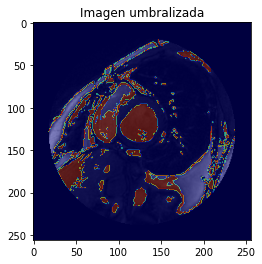

In [5]:
# UMBRALIZADO: Primero implementaremos el método de umbralizado. Para ello establecemos los límites
lower = 40
upper = 80

# La siguiente línea es útil para explorar el rango de valores en que se permitirá crecer a la región
seg = (img > lower) & (img < upper)

# Visualizamos la imagen y su umbralización
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
plt.imshow(sitk.GetArrayFromImage(seg), cmap='jet', alpha=0.5)
plt.title('Imagen umbralizada')

Text(0.5, 1.0, 'Crecimiento de Regiones')

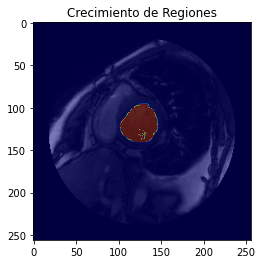

In [6]:
# REGION GROWING: Procedemos a añadir una lista de puntos semilla para los cuales se crecerá
# la región sobre la semillas

seedlist = [(125,125), (130,130) ]

# Aqui llamaremos al método de crecimiento de regiones, indicando la posición de las semillas y los límites para el crecimiento.
seg = sitk.ConnectedThreshold(img, seedList= seedlist, lower= lower , upper= upper )

# Visualizamos la imagen y el gt
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
plt.imshow(sitk.GetArrayFromImage(seg), cmap='jet', alpha=0.5)
plt.title('Crecimiento de Regiones')

Refinamos la segmentación usando el método `sitk.BinaryFillhole` para rellenar los huecos que puedan haber quedado.


Text(0.5, 1.0, 'Segmentación refinada')

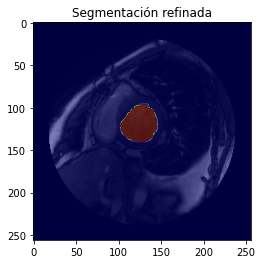

In [7]:
# Refinar la segmentación usando el método 'sitk.BinaryFillhole' para rellenar los huecos 
# que puedan haber quedado.

refinedSeg = sitk.BinaryFillhole(seg)

# Visualizamos la imagen y el gt
plt.figure()
plt.grid(False)
plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
plt.imshow(sitk.GetArrayFromImage(refinedSeg), cmap='jet', alpha=0.5)
plt.title('Segmentación refinada')


# Cómputo del Dice y Haussdorf comparando ambas segmentaciones

Ahora procederemos a usar el método `medpy.metrics.dc(pred, gt)` (Dice) y `medpy.metrics.hc(pred, gt)` (Haussdorf) para evaluar la calidad de nuestras segmentaciones semi-automáticas u.

Recordar que a los métodos "dc" y "hc" es necesario pasarle como parámetro matrices numpy. Éstas pueden ser extraídas a partir de una imagen SimpleITK usando el método: sitk.GetArrayFromImage(img).




In [8]:
gtNumpy = sitk.GetArrayFromImage(gt)
segNumpy = sitk.GetArrayFromImage(seg)
refinedSegNumpy = sitk.GetArrayFromImage(refinedSeg)

print("Dice para crecimiento de regiones: " + str(metrics.dc(gtNumpy,segNumpy)))
print("Dice para crecimiento de regiones refinado: " + str(metrics.dc(gtNumpy,refinedSegNumpy)))

print("Hausdorff (en pixeles) para crecimiento de regiones: " + str(metrics.hd(gtNumpy,segNumpy)))
print("Haussdorf (en pixeles) para crecimiento de regiones refinado: " + str(metrics.hd(gtNumpy,refinedSegNumpy)))


Dice para crecimiento de regiones: 0.9346040092014459
Dice para crecimiento de regiones refinado: 0.9422512234910277
Hausdorff (en pixeles) para crecimiento de regiones: 17.0
Haussdorf (en pixeles) para crecimiento de regiones refinado: 4.47213595499958


# UNet para segmentación de imágenes en PyTorch

En la sección anterior, segmentamos una imagen usando el clásico método de crecimiento de regiones implementado en SimpleITK.

Ahora vamos a entrenar una red convolucional con arquitectura U-Net para hacer lo mismo.

## Definición de Dataset propio

Para entrenar el modelo, ya que estamos utilizando un dataset propio, es conveniente cargarlo como Dataset de PyTorch. Esto nos permitirá llamar a funciones como DataLoader que se encargan de la generación de batches de forma automática.

Para más información sobre Datasets y Dataloaders, ver https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Definición del modelo

Ahora procedemos a definir el modelo U-Net a utilizar.

* Para facilitar la implementación, se recomienda utilizar convoluciones que no modifiquen el tamaño de la entrada (por ejemplo, convoluciones 2D con kernel de tamaño 3x3, padding = 1 y stride = 1).

* La UNet deberá tener 3 niveles de Max Pooling (de 2 x 2) en el encoder, hasta llegar al cuello de botella en el cuarto nivel. A partir de allí, el decoder deberá contar con 3 niveles de UpSampling, que podrán implementarlo usando la técnica de interpolado bilineal (`torch.nn.Upsample` con los parámetros `(scale_factor=2, mode='bilinear', align_corners=True)`) seguida de **dos** convoluciones.

* Para implementar las Skip Connections, deberán utilizar el método `torch.cat` para concatenar los feature maps del encoder con los del decoder en cada nivel.

* Se recomienda utilizar ReLU como función de no linealidad.

* En cuanto a la cantidad de feature maps, se puede utilizar:
  * Nivel 1: 32 Feature maps
  * Nivel 2: 64 Feature maps
  * Nivel 3: 128 Feature maps
  * Nivel 4: 256 Feature maps

* En la última capa, se recomienda finalizar con una convolución con un kernel de 1x1 que transforme los últimos 32 feature maps en un sólo feature map, y posteriormente utilizar la función no lineal `sigmoid`, generando como salida un único feature map que contendrá la probabilidad de que el pixel sea de clase `foreground`.


In [9]:
from utils.modelUnet import UNet 

# Entrenar el modelo

A continuación definimos un trainer, que hará el loop de entrenamiento y validación, para entrenar el modelo. A diferencia del práctico anterior, donde directamente definíamos el código de entrenamiento en la celda, acá definiremos una función 'trainer' que luego será llamada desde otra celda, para ordenar de mejor forma el código.

Utilizaremos como función de pérdida la Soft Dice que vimos en teoría, con una pequeña variación para evitar inestabilidades.


In [10]:
import torch.nn.functional as F
import medpy.metric.binary as metrics

def trainer(train_dataset, val_dataset, model,BN:bool, args):
    ## Recibe dos dataset de PyTorch, el modelo y un diccionario de argumentos
    torch.manual_seed(42)

    # Observa si hay GPU disponible, o manda a CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Current device is', device)
    model = model.to(device)
    dice_loss = DiceLoss().to(device)

    # Carga los argumentos para el dataloader
    train_kwargs = {'batch_size':args['batch_size']}
    val_kwargs = {'batch_size':args['val_batch_size']}

    # El dataloader recibe argumentos sobre el uso de la GPU, por defecto los siguientes
    cuda_kwargs = {'num_workers': 0,
                    'pin_memory': False,
                    'shuffle': True}

    train_kwargs.update(cuda_kwargs)
    val_kwargs.update(cuda_kwargs)

    # Instancio los DataLoaders, que se encargarán de generar batches de datos de manera online
    train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, **val_kwargs)

    # Defino el optimizador, con lr y weight decay preestablecido en el diccionario de argumentos
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=args['lr'], weight_decay=args['weight_decay'])

    # Genero listas para guardar el valor de las funciones de costo promedio por épocas
    train_loss_avg = []
    val_dice_avg = []

    # Mejor valor de Dice, para obtener el mejor modelo en validación
    best = 0

    print('Training ...')
    
    wo = "BN" if BN else "nBN"
    for epoch in range(args['epochs']):
        model.train()

        train_loss_avg.append(0)
        num_batches = 0

        for sample_batched in train_loader:
            image, label = sample_batched['image'].to(device), sample_batched['label'].to(device)

            outseg = model(image)

            # backpropagation
            optimizer.zero_grad()

            loss = dice_loss( outseg , label )

            train_loss_avg[-1] += loss.item()

            loss.backward()

            # one step of the optimizer (using the gradients from backpropagation)
            optimizer.step()
            num_batches += 1
            torch.cuda.empty_cache()

        train_loss_avg[-1] /= num_batches

        print('Epoch [%d / %d] train average loss (1 - Dice): %f' % (epoch+1, args['epochs'], train_loss_avg[-1]))

        ## Comienzo la etapa de validación
        num_batches = 0

        model.eval()
        val_dice_avg.append(0)

        # Sin calcular gradientes y con el modelo en modo eval()
        with torch.no_grad():
            for sample_batched in val_loader:
                image, label = sample_batched['image'].to(device), sample_batched['label'].to(device)

                # Modelo de 1 sola clase de salida
                seg = model(image)[0,0,:,:] # Tomo la primer imagen del batch, y el único canal ya que tiene solo una clase como salida
                binary = seg > 0.5 # Binarizo la segmentacion (que se encuentra en el rango 0-1 por la sigmoidea)

                val_dice_avg[-1] += metrics.dc(binary.cpu().numpy(), label.cpu().numpy()) # Calculo Dice sobre la Clase 1
                num_batches += 1

                loss_rec = 0
                torch.cuda.empty_cache()

        val_dice_avg[-1] /= num_batches

        print('Epoch [%d / %d] validation average dice coefficient: %f' % (epoch+1, args['epochs'], val_dice_avg[-1]))
    
        if val_dice_avg[-1] > best:
            best = val_dice_avg[-1]
            print('Model Saved')
            torch.save(model.state_dict(), f"Practica4/best{wo}.pt")

        torch.save(model.state_dict(), f"Practica4/aux{wo}.pt")
    # Diccionario a devolver
    history = {
      'Train_Loss' : train_loss_avg,
      'Val_Dice' : val_dice_avg
    }

    return history

Una vez definido el trainer, procedemos a instanciar los datasets, el modelo y comenzar el entrenamiento

In [11]:
train_dataset = OurDataset(PATH = dirs['TRAIN_DATA_DIR'],
                          transform = transforms.Compose([
                                      ToTensor()])
                          )

val_dataset = OurDataset(PATH = dirs['VAL_DATA_DIR'],
                        transform = transforms.Compose([
                                    ToTensor()])
                        )
print('Cantidad de imágenes de Entrenamiento', train_dataset.__len__())
print('Cantidad de imágenes de Validacion', val_dataset.__len__())
BN = True # true para usar BatchNormalization y false para no.
modelBN = UNet(1,BN).float()
modelnBN = UNet(1,False).float()

Cantidad de imágenes de Entrenamiento 470
Cantidad de imágenes de Validacion 279


In [12]:
## Acá definimos los hiperparámetros de entrenamiento
args = {
    'batch_size':24, 'val_batch_size':1,'epochs':5,'lr':1e-4,'weight_decay':1e-5
}
history_BN  = trainer(train_dataset, val_dataset, modelBN,True, args)
history_nBN = trainer(train_dataset, val_dataset, modelnBN,False, args)

Current device is cuda:0
Training ...
Epoch [1 / 5] train average loss (1 - Dice): 0.934319
Epoch [1 / 5] validation average dice coefficient: 0.032419
Model Saved
Epoch [2 / 5] train average loss (1 - Dice): 0.909805
Epoch [2 / 5] validation average dice coefficient: 0.210598
Model Saved
Epoch [3 / 5] train average loss (1 - Dice): 0.898611
Epoch [3 / 5] validation average dice coefficient: 0.457600
Model Saved
Epoch [4 / 5] train average loss (1 - Dice): 0.893452
Epoch [4 / 5] validation average dice coefficient: 0.689180
Model Saved
Epoch [5 / 5] train average loss (1 - Dice): 0.888605
Epoch [5 / 5] validation average dice coefficient: 0.715898
Model Saved
Current device is cuda:0
Training ...
Epoch [1 / 5] train average loss (1 - Dice): 0.969566
Epoch [1 / 5] validation average dice coefficient: 0.000000
Epoch [2 / 5] train average loss (1 - Dice): 0.969450
Epoch [2 / 5] validation average dice coefficient: 0.000000
Epoch [3 / 5] train average loss (1 - Dice): 0.968483
Epoch [3 / 5

Procedemos a plotear los valores de la funcion de costo en Train y del Coeficiente Dice en Validacion.

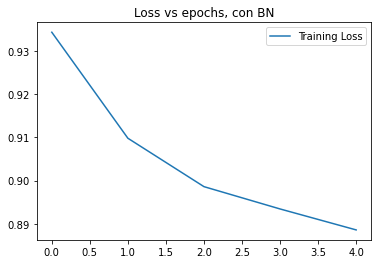

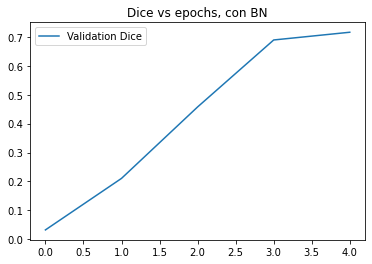

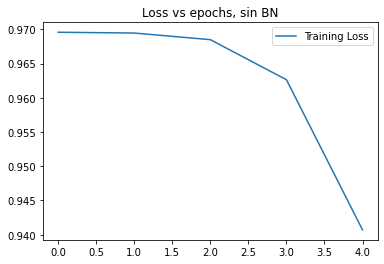

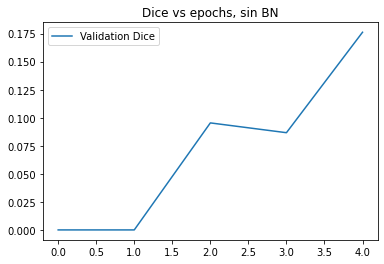

In [13]:
from utils.graphs import g_loss_dice
g_loss_dice(history_BN,True)
g_loss_dice(history_nBN,False)

# Testeando el modelo y generando imágenes de salida

Una vez entrenado el modelo, procedemos a generar las predicciones sobre las imágenes de test.



In [14]:
test_dataset = OurDataset(PATH = dirs['TEST_DATA_DIR'],
                          transform = transforms.Compose([
                                      Rescale(256),
                                      ToTensor()])
                          )

print('Cantidad de imágenes de prueba', test_dataset.__len__())

## Obtengo una imagen de test y la muestro
sample = test_dataset[34]
image, label = sample['image'], sample['label']

Cantidad de imágenes de prueba 56


Shape: torch.Size([1, 1, 256, 256]) BatchSize x Channels x Height x Width


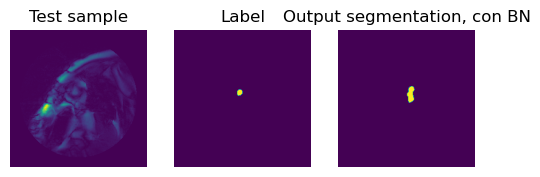

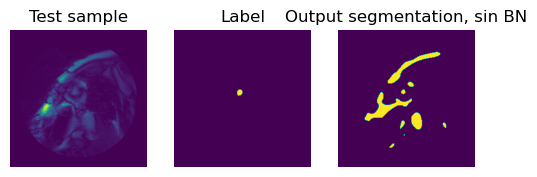

In [15]:
from utils.graphs import img_test
## Cargo los pesos entrenados
modelBN.load_state_dict(torch.load('Practica4/bestBN.pt'))
modelnBN.load_state_dict(torch.load('Practica4/bestnBN.pt'))

modelBN.to(device)
modelnBN.to(device)

## Le agrego el batchsize = 1 a la imagen
data = image.unsqueeze(axis=1).to(device)
print('Shape:', data.shape, 'BatchSize x Channels x Height x Width')

# Segmento la imagen
with torch.no_grad():
    seg1 = modelBN(data)[0,0,:,:] # quitando el batchsize
    seg2 = modelnBN(data)[0,0,:,:] # quitando el batchsize

img_test(image,label,seg1,True)
img_test(image,label,seg2,False)

# Visualizando resultados de test

Crear un dataloader para el dataset de test y evaluar el coeficiente Dice y la distancia de Haussdorf de todas las imágenes de test. Reportar el resultado en un boxplot.

In [24]:
grap_dice_BN = np.zeros(test_dataset.__len__())
grap_dice_nBN = np.zeros(test_dataset.__len__())
grap_h_BN = np.zeros(test_dataset.__len__())
grap_h_nBN = np.zeros(test_dataset.__len__())
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1)
for it,sample_batched in enumerate(test_loader):
    image, label = sample_batched['image'].to(device), sample_batched['label'].to(device)
    data = image.unsqueeze(axis=0)[0,:,:,:].to(device)
    label = label[0,:,:]
    with torch.no_grad():
        seg1 = modelBN(data)[0,0,:,:] # quitando el batchsize
        seg2 = modelnBN(data)[0,0,:,:] # quitando el batchsize
    binary1 = seg1 > 0.5
    binary2 = seg2 > 0.5
    grap_dice_BN[it] = metrics.dc(binary1.cpu().numpy(), label.cpu().numpy())
    grap_dice_nBN[it] = metrics.dc(binary2.cpu().numpy(), label.cpu().numpy())
    if np.unique(binary1.cpu().numpy()).size != 1 : # quiere decir que no solo son falses
        grap_h_BN[it] = metrics.hd(binary1.cpu().numpy(), label.cpu().numpy())
    if np.unique(binary2.cpu().numpy()).size != 1 : # quiere decir que no solo son falses
        grap_h_nBN[it] = metrics.hd(binary2.cpu().numpy(), label.cpu().numpy())
        
torch.cuda.empty_cache()

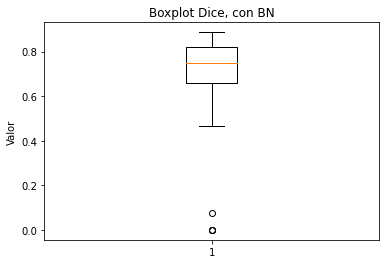

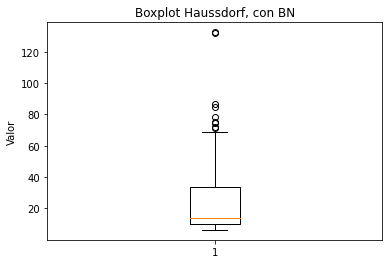

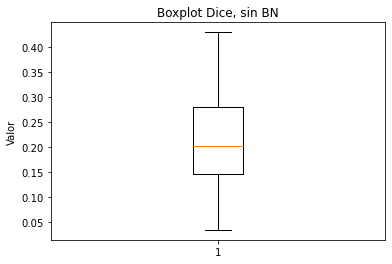

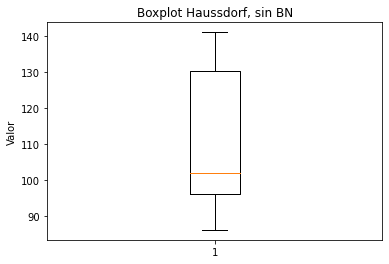

In [25]:
from utils.graphs import Boxplots
Boxplots(grap_dice_BN,grap_h_BN,True)
Boxplots(grap_dice_nBN,grap_h_nBN,False)

# Entregable:

1. Deberán implementar la arquitectura UNet y reportar los resultados en los datos de test, reportando el coeficiente Dice y el coeficiente Haussdorf mediante un boxplot.

2. Luego deberán incorporarle Batch Normalization (utilizando la clase `torch.nn.BatchNorm2d`) en las capas convolucionales de dicha arquitectura (en todas excepeto en la última) y comparar el rendimiento con el modelo sin Batch Normalization. Recordar que BatchNorm se coloca a la salida de la capa, antes de pasar por la función de activación.